### 数据处理
- 保证点击率一致的情况下，让数据减少到500w
- 500w的数据占原来数据比例是18%，所以正负样本都以18%的比例进行采样

In [1]:
import numpy as np
import pandas as pd
import datetime
data_path = '/home/suibe/dev_sjl/毕业论文/data/'
ad_features = pd.read_csv(data_path + 'ad_feature.csv')
# raw_sample = pd.read_csv(data_path + 'raw_sample.csv')
user_profile = pd.read_csv(data_path + 'user_profile.csv')
user_profile.rename(columns={'userid' : 'user_id'}, inplace=True)
# behavior_log = pd.read_csv(data_path + 'behavior_log.csv')

### 一、采样raw_sample

In [3]:
#处理原始数据
raw_sample.rename(columns={'user': 'user_id'}, inplace=True)
raw_sample['time_stamp'] = pd.to_datetime(raw_sample['time_stamp'], unit='s')
raw_sample.drop(columns=['nonclk'], inplace = True)

In [114]:
# 正负样本采样
pos_user = raw_sample[raw_sample['clk'] == 1].user_id.unique()
neg_user = raw_sample[raw_sample['clk'] == 0].user_id.unique()
pos_user = np.random.choice(pos_user, int(len(pos_user) * 0.02), replace=False)
neg_user = np.random.choice(neg_user, int(len(neg_user) * 0.01), replace=False)
pos_sample = raw_sample[raw_sample['user_id'].isin(pos_user)]
neg_sample = raw_sample[raw_sample['user_id'].isin(neg_user)]
sample = pd.concat([pos_sample, neg_sample]).reset_index(drop=True)

In [116]:
# sample.to_csv(data_path + 'sample.csv', index=False)
# sample.groupby('clk').size()

clk
0    657372
1     40976
dtype: int64

In [2]:
# sample = sample[sample['user_id'].isin(behavior_user)]
# sample.to_csv(data_path + 'sample.csv', index=False)
sample = pd.read_csv(data_path + 'sample.csv')

### 二、处理序列数据

In [84]:
behavior_user = behavior_log[behavior_log['user'].isin(sample['user_id'].unique())]['user'].unique() #保证每个user都有序列

In [13]:
behavior_log['time_stamp'] = pd.to_datetime(behavior_log['time_stamp'], unit='s')

In [120]:
# 采样数据中每个用户的最小时间戳
user_first = sample.groupby(['user_id'])['time_stamp'].min().reset_index()

In [63]:
# 行为日志中，找到sample用户的起始时间戳
# behavior_user_first = behavior_log.groupby(['user'])['time_stamp'].max().reset_index()
# behavior_user_first = behavior_user_first[behavior_user_first.user.isin(user_first.user_id.unique())]

In [121]:
# 将行为log转化为sample里有的user的
behavior_log = behavior_log[behavior_log['user'].isin(user_first.user_id.unique())]

In [124]:
behavior_cnt = behavior_log.groupby(['user']).size().reset_index(name='count').sort_values(by='count', ascending=False)

In [125]:
behavior_cnt.to_csv(data_path + 'behavior_cnt.csv', index=False)

In [127]:
# 将用户行为log中每一个用户的序列时间限制在点击日志之后
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sample_behavior_log = pd.DataFrame(columns=behavior_log.columns)
for user in tqdm(user_first.user_id.unique()):
    user_behavior_log = behavior_log[behavior_log['user'] == user]
    user_behavior_log = user_behavior_log[user_behavior_log['time_stamp'] <= user_first[user_first.user_id == user].time_stamp.values[0]]
    sample_behavior_log = pd.concat([sample_behavior_log, user_behavior_log], ignore_index=True)

  0%|          | 0/13362 [00:00<?, ?it/s]

100%|██████████| 13362/13362 [45:00<00:00,  4.95it/s]


In [130]:
sample_behavior_log.to_csv(data_path + 'sample_behavior_log.csv', index=False)

In [3]:
sample_behavior_log = pd.read_csv(data_path + 'sample_behavior_log.csv')

In [4]:
sample_behavior_cnt = sample_behavior_log.groupby(['user','brand']).size().reset_index(name='count').sort_values(by='count', ascending=False)

In [23]:
behavior_cnt_300 = sample_behavior_cnt[sample_behavior_cnt['count'] >= 300]

<Figure size 1500x400 with 0 Axes>

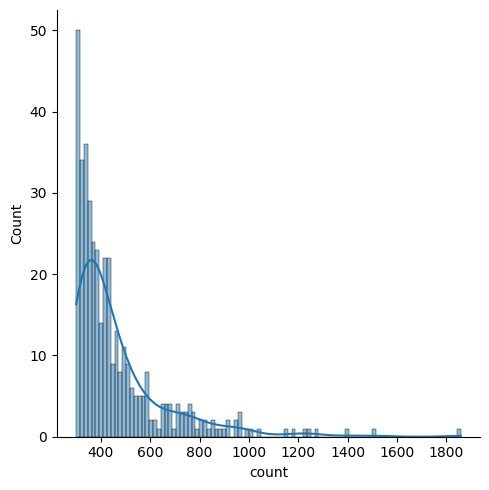

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 4))
sns.displot(behavior_cnt_300, x='count', bins=100, kde=True)

<AxesSubplot:ylabel='Density'>

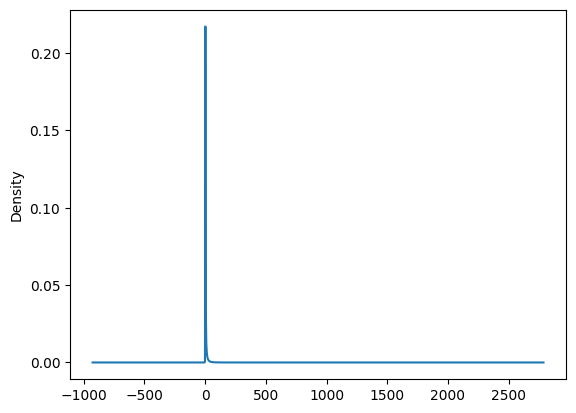

In [10]:
sample_behavior_cnt['count'].plot(kind='kde')

In [5]:
sample_behavior_log = sample_behavior_log.sort_values(by=['user', 'time_stamp'], ascending=[True, True])
sample_behavior_log

,user,time_stamp,btag,cate,brand
273,3,2017-04-24 10:08:18,pv,4603,151043
275,3,2017-04-24 10:10:58,buy,4603,151043
268,3,2017-04-24 10:13:20,pv,6432,253841
264,3,2017-04-24 10:13:21,pv,6432,253841
272,3,2017-04-24 10:13:23,pv,6432,253841
...,...,...,...,...,...
7511895,1141718,2017-05-06 07:32:08,pv,7340,101384
7511896,1141718,2017-05-06 07:35:11,pv,7340,101384
7511897,1141718,2017-05-06 07:37:08,pv,7340,101384
7511894,1141718,2017-05-06 07:37:31,pv,7340,101384


In [7]:
#  btag序列
btag_hist = sample_behavior_log.groupby('user')['btag'].apply(list).reset_index().rename(columns={'btag': 'btag_hist','user':'user_id'})
# cate序列
cate_hist = sample_behavior_log.groupby('user')['cate'].apply(list).reset_index().rename(columns={'cate': 'cate_hist','user':'user_id'})
# brand序列
brand_hist = sample_behavior_log.groupby('user')['brand'].apply(list).reset_index().rename(columns={'brand': 'brand_hist','user':'user_id'})
# 时间戳序列
time_hist = sample_behavior_log.groupby('user')['standard_time'].apply(list).reset_index().rename(columns={'standard_time': 'time_hist','user':'user_id'})

### 三、特征拼接

In [16]:
btag_hist

,user_id,btag_hist
0,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,73,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
2,93,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, ..."
3,107,"[3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,109,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, ..."
...,...,...
13306,1141515,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, ..."
13307,1141517,"[3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, ..."
13308,1141599,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
13309,1141711,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."


In [8]:
sample = pd.merge(sample, ad_features, on = 'adgroup_id', how = 'left')
sample = pd.merge(sample, user_profile, on = 'user_id', how = 'left')
sample = pd.merge(sample, btag_hist, on = 'user_id', how = 'left')
sample = pd.merge(sample, cate_hist, on = 'user_id', how = 'left')
sample = pd.merge(sample, brand_hist, on = 'user_id', how = 'left')
sample = pd.merge(sample, time_hist, on = 'user_id', how = 'left')
sample

,user_id,time_stamp,adgroup_id,pid,clk,cate_id,campaign_id,customer,brand,price,...,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,btag_hist,cate_hist,brand_hist,time_hist
0,1062691,2017-05-10 23:43:21,102,430539_1007,0,126,138148,20107,102457.0,98.00,...,2.0,3.0,NaN,3.0,0.0,3.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[4282, 6185, 133, 4278, 6508, 10062, 133, 1174...","[318890, 200496, 361042, 14983, 24011, 289869,...","[0.07640731789698882, 0.08414164482186712, 0.0..."
1,1062691,2017-05-06 23:46:58,102,430539_1007,0,126,138148,20107,102457.0,98.00,...,2.0,3.0,NaN,3.0,0.0,3.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[4282, 6185, 133, 4278, 6508, 10062, 133, 1174...","[318890, 200496, 361042, 14983, 24011, 289869,...","[0.07640731789698882, 0.08414164482186712, 0.0..."
2,845154,2017-05-09 11:07:25,102,430548_1007,0,126,138148,20107,102457.0,98.00,...,2.0,3.0,NaN,3.0,0.0,3.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, ...","[6512, 6512, 6512, 6512, 6512, 6512, 5328, 112...","[307734, 307734, 307734, 307734, 307734, 30773...","[0.08475013138048393, 0.0846167172563859, 0.08..."
3,779120,2017-05-12 01:08:01,102,430548_1007,0,126,138148,20107,102457.0,98.00,...,2.0,3.0,2.0,3.0,0.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[9095, 8998, 8998, 8998, 8998, 11123, 6519, 65...","[257348, 60561, 60561, 60561, 60561, 261348, 2...","[0.08775145686964854, 0.08713780112910172, 0.0..."
4,779120,2017-05-08 08:12:33,102,430548_1007,0,126,138148,20107,102457.0,98.00,...,2.0,3.0,2.0,3.0,0.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[9095, 8998, 8998, 8998, 8998, 11123, 6519, 65...","[257348, 60561, 60561, 60561, 60561, 261348, 2...","[0.08775145686964854, 0.08713780112910172, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648042,1090593,2017-05-06 00:24:56,846248,430548_1007,0,6022,130479,6439,NaN,1.33,...,2.0,3.0,2.0,3.0,0.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[6423, 4281, 4612, 4281, 6423, 6426, 5920, 592...","[4646, 43425, 197848, 43425, 448415, 404586, 6...","[0.018202575516740076, 0.03626271257406862, 0...."
648043,605615,2017-05-13 06:59:31,846342,430548_1007,0,6432,384178,35687,196981.0,119.00,...,2.0,3.0,2.0,3.0,0.0,3.0,"[3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, ...","[4283, 6416, 6251, 6423, 6415, 6415, 392, 392,...","[430318, 7226, 113690, 57548, 7226, 7226, 2213...","[0.08653866832826299, 0.07287110515382975, 0.0..."
648044,1136231,2017-05-08 09:26:18,846496,430539_1007,0,6446,152055,24113,214828.0,520.00,...,1.0,3.0,2.0,3.0,0.0,4.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[6341, 6341, 6341, 6341, 6341, 6341, 6341, 634...","[87805, 87805, 87805, 87805, 87805, 87805, 878...","[0.08307900870797197, 0.08308639325358624, 0.0..."
648045,451598,2017-05-12 07:12:12,846595,430548_1007,0,4509,396627,26505,NaN,3.75,...,1.0,4.0,2.0,3.0,0.0,3.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[5870, 4596, 4596, 4281, 4283, 4627, 4627, 462...","[405129, 183237, 183237, 69045, 430318, 252677...","[0.08389549330139105, 0.016846772941957938, 0...."


In [10]:
sample.fillna(0, inplace=True)